Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

In [65]:
import numpy as np
import itertools
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from typing import List, NamedTuple, Union, Callable, Tuple
from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector

# pip install -U scikit-learn
from sklearn.datasets import make_blobs

In [66]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

Now, we are going to dealing with a *modeling* data which is so-called *clustering*. The data does not provide label, and the model
will try to put some labels on it.

## The Idea

Every data that is generated from such process (not truly random), will have a   
kind of distribution around specific cluster.

When you are deciding which clustering scheme is better than another, you have   
to follow the metric that you want to achieve.

Clustering is a pattern that emerges from the data and there is no correct   
cluster and it only depends on the scheme and metric that you used to do clustering.

Doing clustering, is finding a pattern that somehow represents the underlying   
principle of the data.


## The Model

The input data consists of a vector in $d$-dimensional space, and our goal is   
to find the representative input that identify the cluster of input data that   
has similarities among themselves.

Examples of clustering are finding the what the people are writing about in   
their blog by finding the cluster of blog's title

By doing clustering, we hope that we can find something useful about the   
underlying data specifically the similarities among data points.

The simplest example of clustering technique is $k$-means.

To solve clustering problem, we can use a simplest procedure $k$-means

$k$-means is an iterative algorithm that updates randomly pre-selected   
centroids based on the collected nearest neigbour to those centroids.

$k$-means is an iterative algorithm that update randomly pre-selected centroid   
that can solve clustering problem 

An example of [$k$-means animation](https://www.youtube.com/watch?v=5I3Ei69I40s)

In Python we can solve clustering problem using function `vector_mean` from Chapter 4

We create a helper function to track how many coordinates two vectors differ in.

In [67]:
def num_differences(v1: Vector, v2: Vector, tol: float = 1e-5) -> int:
  assert len(v1) == len(v2)
  return len([x1 for x1, x2 in zip(v1, v2) if abs(x1-x2) > tol])


print(f"{num_differences([1, 2, 3], [2, 1, 3])}")
print(f"{num_differences([1, 2], [1, 2])}")

2
0


Create a function that for given some vectors and their
assignment to cluster, computes the means of the clusters

In [68]:
def cluster_means(k: int, inputs: List[Vector], assignments: List[int], rng) -> List[Vector]:

  # clusters[i] contains the inputs whose assignment is i
  clusters = [[] for i in range(k)]
  for input, assignment in zip(inputs, assignments):
    clusters[assignment].append(input)

  # if a cluster is empty, just use a random point
  return [la.vector_mean(cluster) if cluster else rng.choice(inputs)
          for cluster in clusters]

[You do not need to understand the following code]

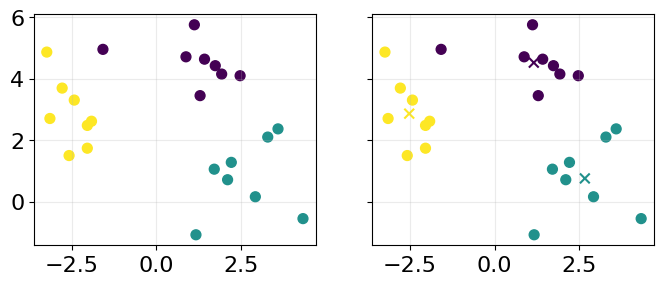

In [69]:
X, y = make_blobs(n_samples=24, centers=3, cluster_std=1., random_state=0)
k = len(np.unique(y))
rng = np.random.default_rng(24_03_31)
means = np.array(cluster_means(k, X, y, rng))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)

cmap = "viridis"
axes[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
axes[0].grid("on")

axes[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
axes[1].scatter(means[:, 0], means[:, 1], c=np.arange(k), s=50, marker="x", cmap=cmap)
axes[1].grid("on")

plt.show(fig)

In [70]:
k = 3
X, _ = make_blobs(n_samples=24, centers=k, cluster_std=1., random_state=0)
rng = np.random.default_rng(24_03_31)
y_rand = [rng.integers(k) for _ in X]
means = np.array(cluster_means(k, X, y_rand, rng))

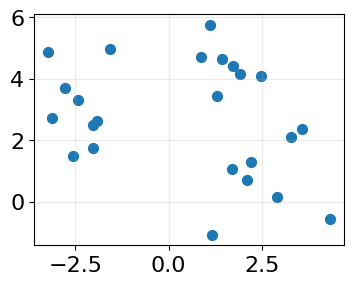

In [71]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.scatter(X[:, 0], X[:, 1], color="tab:blue", s=50)
ax.grid("on")

plt.show(fig)

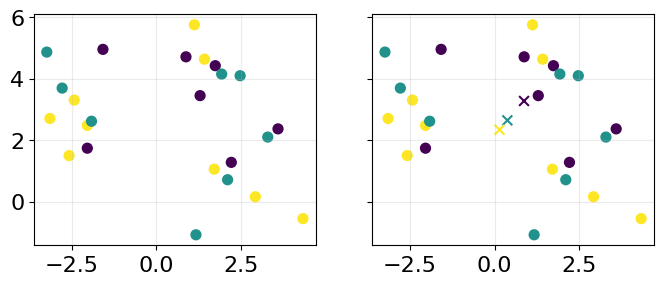

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)

cmap = "viridis"
axes[0].scatter(X[:, 0], X[:, 1], c=y_rand, s=50, cmap=cmap)
axes[0].grid("on")

axes[1].scatter(X[:, 0], X[:, 1], c=y_rand, s=50, cmap=cmap)
axes[1].scatter(means[:, 0], means[:, 1], c=np.arange(k), s=50, marker="x", cmap=cmap)
axes[1].grid("on")

plt.show(fig)

In [73]:
  def classify(k: int, means: List[List[float]], input_: Vector) -> int:
    """return the index of the cluster closest to the input"""
    return min(range(k), 
      key=lambda i: la.squared_distance(input_, means[i]))

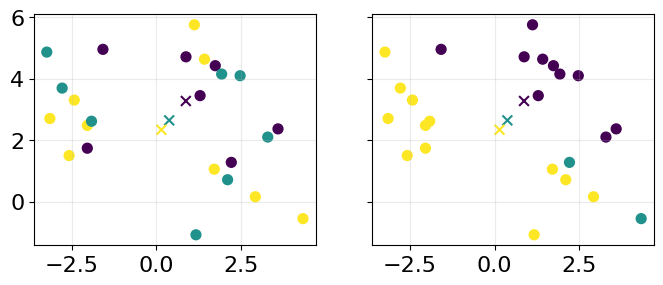

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)

cmap = "viridis"

axes[0].scatter(X[:, 0], X[:, 1], c=y_rand, s=50, cmap=cmap)
axes[0].scatter(means[:, 0], means[:, 1], c=np.arange(k), s=50, marker="x", cmap=cmap)
axes[0].grid("on")

new_y = [classify(k, means, input_) for input_ in X]
axes[1].scatter(X[:, 0], X[:, 1], c=new_y, s=50, cmap=cmap)
axes[1].scatter(means[:, 0], means[:, 1], c=np.arange(k), s=50, marker="x", cmap=cmap)
axes[1].grid("on")

plt.show(fig)


Now we are going to construct a class for doing $k$-means clustering

In [75]:
class KMeans(object):
  def __init__(self, k: int) -> None:
    self.k = k            # number of clusters
    self.means = None
    self.means_init = None

  def classify(self, input_: Vector) -> int:
    """return the index of the cluster closest to the input"""
    return min(range(self.k), 
      key=lambda i: la.squared_distance(input_, self.means[i]))

  def train(self, inputs: List[Vector], seed: int = 2023_04_27) -> None:
    # Start with random assignments
    rng = np.random.default_rng(seed)
    assignments = [rng.integers(self.k) for _ in inputs]

    with tqdm.tqdm(itertools.count()) as t:
      for _ in t:
        # Compute means and find new assignments
        self.means = cluster_means(self.k, inputs, assignments, rng)
        if _ == 0:
          self.means_init = self.means

        new_assignments = [self.classify(input_) for input_ in inputs]

        # Check how many assignments changed and if we're done
        num_changed = num_differences(assignments, new_assignments)
        if num_changed == 0:
          return

        # Otherwise keep the new assignments, and compute new means
        assignments = new_assignments.copy()
        self.means = cluster_means(self.k, inputs, assignments, rng)
        t.set_description(f"changed: {num_changed} / {len(inputs)}")

## Example: Meetups

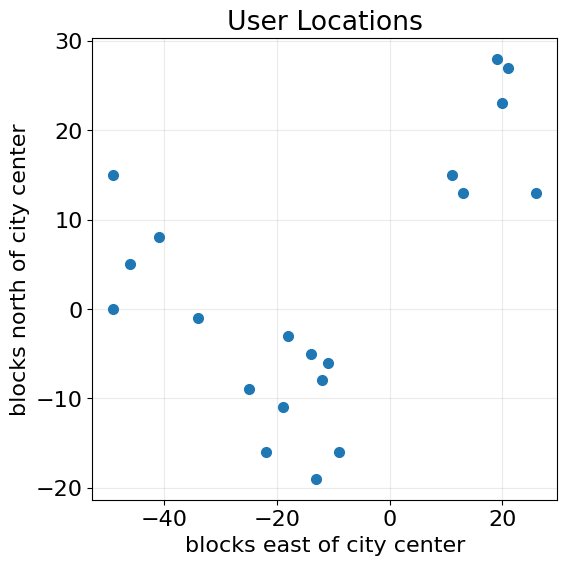

In [76]:
# Meetups locations
inputs: List[List[float]] \
  = [[-14,  -5], [ 13, 13], [ 20,  23], [-19, -11], [ -9, -16],
     [ 21,  27], [-49, 15], [ 26,  13], [-46,   5], [-34,  -1],
     [ 11,  15], [-49,  0], [-22, -16], [ 19,  28], [-12,  -8],
     [-13, -19], [-41,  8], [-11,  -6], [-25,  -9], [-18,  -3]]

fig, ax = plt.subplots(figsize=(6, 6))

x_data = [xi for xi, _ in inputs]
y_data = [yi for _, yi in inputs]
ax.plot(x_data, y_data, marker='o', linestyle='None', markersize=7)

ax.set_xlabel("blocks east of city center")
ax.set_ylabel("blocks north of city center")
ax.grid("on")
ax.set_title("User Locations")

plt.show(fig)

Do clustering for three meetups location

In [77]:
seed = 2023_04_27

clusterer = KMeans(k=3)
clusterer.train(inputs, seed=seed)
means = sorted(clusterer.means)       # sort for the unit test

assert len(means) == 3

# Check that the means are close to what we expect
assert la.squared_distance(means[0], [-44, 5]) < 1
assert la.squared_distance(means[1], [-16, -10]) < 1
assert la.squared_distance(means[2], [18, 20]) < 1

changed: 12 / 20: : 1it [00:00, ?it/s]


In [78]:
def classify(input_, means):
  k = len(means)
  return min(range(k), key=lambda i: la.squared_distance(input_, means[i]))

def get_cluster(inputs, means):
  idx_cluster = [classify(input_, means) for input_ in inputs]

  cluster_dict = {k: [] for k in range(len(means))}
  for idx, input_ in zip(idx_cluster, inputs):
    cluster_dict[idx].append(input_)

  return cluster_dict

cluster_dict = get_cluster(inputs, means)

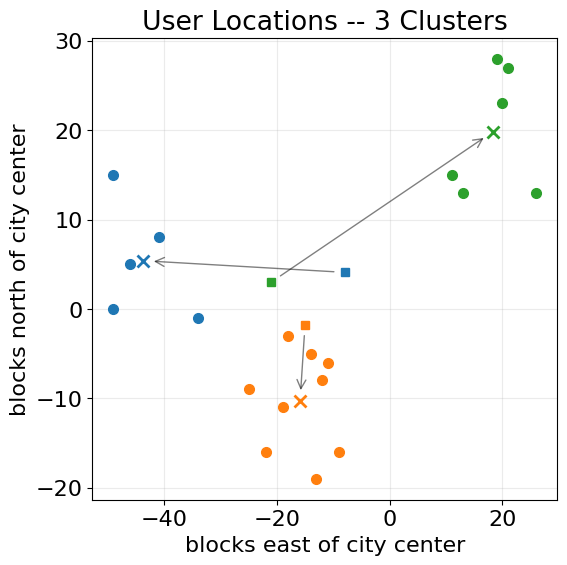

In [79]:
fig, ax = plt.subplots(figsize=(6, 6))


for i in range(len(means)):
  plot_handler = ax.plot(*means[i], marker='x', markeredgewidth=2, markersize=9)
  x_data = [xi for xi, _ in cluster_dict[i]]
  y_data = [yi for _, yi in cluster_dict[i]]

  
  color_kmeans = plot_handler[0]._color
  # print(color_kmeans)
  # plot initial means
  ax.plot(*clusterer.means_init[i], marker='s', color=color_kmeans, 
    )

  ax.annotate("", xy=means[i], xycoords="data", 
              xytext=clusterer.means_init[i], textcoords="data",
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                              shrinkA=8, shrinkB=8, alpha=0.5))

  ax.plot(x_data, y_data, marker='o', linestyle='None', markersize=7, 
    color=color_kmeans)

ax.set_xlabel("blocks east of city center")
ax.set_ylabel("blocks north of city center")
ax.grid("on")
ax.set_title("User Locations -- 3 Clusters")

plt.show(fig)

If we have only two meetups ($k = 2$)

In [80]:
rng = np.random.default_rng(2023_04_27)

clusterer = KMeans(k=2)
clusterer.train(inputs, rng)
means = sorted(clusterer.means)

assert len(means) == 2
assert la.squared_distance(means[0], [-26, -5]) < 1
assert la.squared_distance(means[1], [18, 20]) < 1

changed: 3 / 20: : 3it [00:00, 3000.22it/s]


In [81]:
cluster_dict = get_cluster(inputs, means)

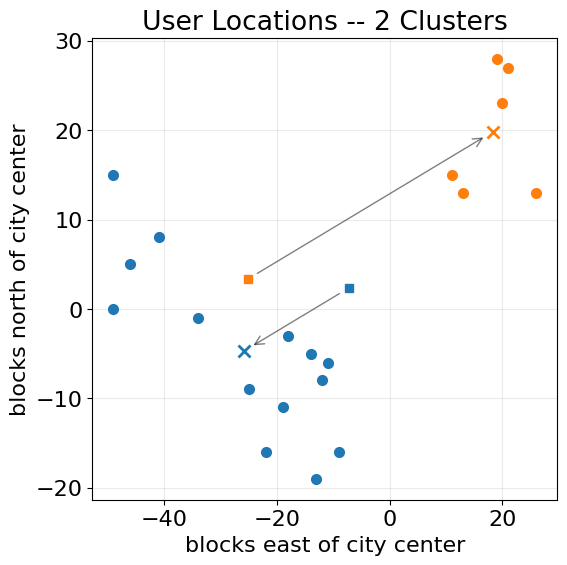

In [82]:
fig, ax = plt.subplots(figsize=(6, 6))


for i in range(len(means)):
  plot_handler = ax.plot(*means[i], marker='x', markeredgewidth=2, markersize=9)
  x_data = [xi for xi, _ in cluster_dict[i]]
  y_data = [yi for _, yi in cluster_dict[i]]

  
  color_kmeans = plot_handler[0]._color
  # print(color_kmeans)
  # plot initial means
  ax.plot(*clusterer.means_init[i], marker='s', color=color_kmeans, 
    )

  ax.annotate("", xy=means[i], xycoords="data", 
            xytext=clusterer.means_init[i], textcoords="data",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                            shrinkA=8, shrinkB=8, alpha=0.5))

  ax.plot(x_data, y_data, marker='o', linestyle='None', markersize=7, 
    color=color_kmeans)

ax.set_xlabel("blocks east of city center")
ax.set_ylabel("blocks north of city center")
ax.grid("on")
ax.set_title("User Locations -- 2 Clusters")

plt.show(fig)

## Choosing $k$

To get the best $k$, we can use the following metrics: plotting
the sum squared errors as a function of $k$ and looking where
the graph "bends"

In [83]:
def square_clustering_errors(inputs: List[Vector], k: int) -> float:
  """finds the total squared error from k-means clustering the inputs"""
  rng = np.random.default_rng(2023_04_27)
  clusterer = KMeans(k)
  clusterer.train(inputs, rng)
  means = clusterer.means  
  assignments = [clusterer.classify(input_) for input_ in inputs]

  return sum(la.squared_distance(input_, means[cluster])
              for input_, cluster in zip(inputs, assignments))

0it [00:00, ?it/s]
changed: 3 / 20: : 3it [00:00, 1274.22it/s]
changed: 12 / 20: : 1it [00:00, 993.44it/s]
changed: 4 / 20: : 2it [00:00, 1820.84it/s]
changed: 3 / 20: : 2it [00:00, 634.59it/s]
changed: 1 / 20: : 3it [00:00, 993.20it/s]
changed: 2 / 20: : 3it [00:00, 872.00it/s]
changed: 2 / 20: : 3it [00:00, 1500.29it/s]
changed: 1 / 20: : 3it [00:00, 913.53it/s]
changed: 1 / 20: : 3it [00:00, 723.28it/s]
changed: 3 / 20: : 3it [00:00, 992.19it/s]
changed: 3 / 20: : 3it [00:00, 915.45it/s]
changed: 2 / 20: : 4it [00:00, 991.62it/s]
changed: 2 / 20: : 3it [00:00, 933.10it/s]
changed: 2 / 20: : 4it [00:00, 790.52it/s]
changed: 6 / 20: : 2it [00:00, 666.77it/s]
changed: 2 / 20: : 3it [00:00, 855.17it/s]
changed: 1 / 20: : 3it [00:00, 532.05it/s]
changed: 1 / 20: : 3it [00:00, 468.25it/s]
changed: 2 / 20: : 3it [00:00, 533.97it/s]


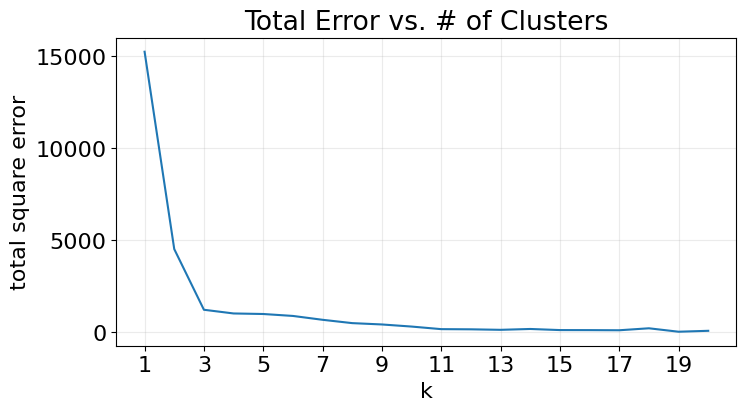

In [84]:
# now plot from 1 up to len(inputs) clusters
ks = range(1, len(inputs) + 1)
errors = [square_clustering_errors(inputs, k) for k in ks]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(ks, errors)

ax.set_xlabel("k")
ax.set_ylabel("total square error")
ax.set_xticks(ks[::2])
ax.grid("on")
ax.set_title("Total Error vs. # of Clusters")

plt.show(fig)

## Example: Clustering Colors

Clustering the colors of an image has a benefits for someone
who wants to redraw the image using $k$ colors.

Read the image

In [132]:
image_path = r"./datasets/2017_AstridS_Press_210917-696x442.jpg"
img = mpimg.imread(image_path) / 256    # rescale to between 0 and 1

img

array([[[0.72265625, 0.4140625 , 0.15625   ],
        [0.71875   , 0.41015625, 0.15234375],
        [0.71875   , 0.41015625, 0.15234375],
        ...,
        [0.53515625, 0.23828125, 0.10546875],
        [0.53515625, 0.23828125, 0.10546875],
        [0.53515625, 0.23828125, 0.10546875]],

       [[0.71875   , 0.41015625, 0.15234375],
        [0.71875   , 0.41015625, 0.15234375],
        [0.71875   , 0.41015625, 0.15234375],
        ...,
        [0.53515625, 0.23828125, 0.10546875],
        [0.53515625, 0.23828125, 0.10546875],
        [0.53515625, 0.23828125, 0.10546875]],

       [[0.71875   , 0.41015625, 0.15234375],
        [0.71875   , 0.41015625, 0.15234375],
        [0.71875   , 0.41015625, 0.15234375],
        ...,
        [0.53515625, 0.23828125, 0.10546875],
        [0.53515625, 0.23828125, 0.10546875],
        [0.53515625, 0.23828125, 0.10546875]],

       ...,

       [[0.76171875, 0.48046875, 0.19140625],
        [0.76171875, 0.48046875, 0.19140625],
        [0.765625  , 0

In [135]:
img.shape

(442, 696, 3)

`img[i][j]` is the pixel in the $i$-th row and $j$-th column, and each pixel
is a list `[red, green, blue]` of numbers between 0 and 1 indicating the color
of the pixel

In [106]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel

print(red, green, blue)

0.72265625 0.4140625 0.15625


We can get a flattened list of all the pixels and feed them to our clusterer

In [87]:
# .tolist() converts a NumPy array to a Python list
pixels = [pixel.tolist() for row in img for pixel in row]

rng = np.random.default_rng(2023_04_27)
clusterer = KMeans(k=5)
clusterer.train(pixels, rng)        # this might take a while (2 minutes 30 seconds)

changed: 3 / 307632: : 38it [01:22,  2.16s/it]    


Construct a new image with the same format

In [88]:
def recolor(pixel: Vector) -> Vector:
  cluster = clusterer.classify(pixel)     # index of the closest cluster
  return clusterer.means[cluster]

new_img = [[recolor(pixel) for pixel in row] for row in img]

Display the `new_img`

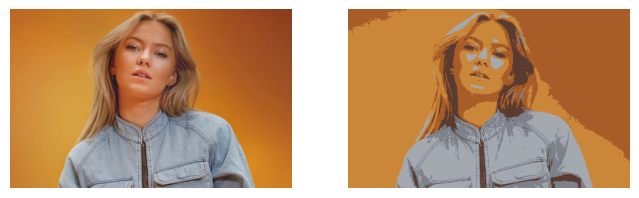

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].imshow(img)
axes[1].imshow(new_img)

axes[0].axis("off")
axes[1].axis("off")

plt.show(fig)

# Bottom-Up Hierarchical Clustering

Another method to do clustering by starting from the bottom (all inputs
are the means of the cluster), merging each point with the closest one.
We will end up get one big cluster.
To get $k$ cluster means, we can do by unmerging.

We use a leaf to represent our cluster

In [108]:
class Leaf(NamedTuple):
  value: Vector


leaf1 = Leaf([10, 20])
leaf2 = Leaf([30, -15])

To grow the cluster, we use the following `Merged` class

In [109]:
class Merged(NamedTuple):
  children: tuple
  order: int


merged = Merged((leaf1, leaf2), order=1)
print(merged)

Cluster = Union[Leaf, Merged]

Merged(children=(Leaf(value=[10, 20]), Leaf(value=[30, -15])), order=1)


Create a recursive function that returns all the values obtained in a (possibly merged) cluster

In [110]:
def get_values(cluster: Cluster) -> List[Vector]:
  if isinstance(cluster, Leaf):
    return [cluster.value]
  else:
    return [value for child in cluster.children
              for value in get_values(child)]
  
get_values(merged)


[[10, 20], [30, -15]]

To merger the closest clusters, we need some notion of the distance between clusters

In [111]:
def cluster_distance(cluster1: Cluster, cluster2: Cluster, distance_agg: Callable = min) -> float:
  """ 
  Compute all the pairwise distance between cluster1 and cluster2
  and apply the aggregation function `distance_agg` to the resulting list
  """ 
  return distance_agg([la.distance(v1, v2) for v1 in get_values(cluster1)
                        for v2 in get_values(cluster2)])

We'll use the merge order slot to track the order in which we did the merging.

In [112]:
def get_merge_order(cluster: Cluster) -> float:
  if isinstance(cluster, Leaf):
    return float('inf')           # was never merged
  else:
    return cluster.order

We also write a helper function to handle `Leaf` cluster that don't have children

In [113]:
def get_children(cluster: Cluster):
  if isinstance(cluster, Leaf):
      raise TypeError("Leaf has no children")

  else:
    return cluster.children

Now, we're ready to create the clustering algorithm from bottop-up approach

In [114]:
def pair_distance(pair: Tuple[Cluster, Cluster], distance_agg: Callable = min) -> float:
  return cluster_distance(pair[0], pair[1], distance_agg)

def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
  # Start with all leaves
  clusters: List[Cluster] = [Leaf(input) for input in inputs]

  # as long as we have more than one cluster left....
  while len(clusters) > 1:
    # find the two closest clusters
    c1, c2 = min(((cluster1, cluster2)
                  for i, cluster1 in enumerate(clusters)
                    for cluster2 in clusters[:i]),
                 key=lambda pair: pair_distance(pair, distance_agg))
    
    # remove them from the list of clusters
    clusters = [c for c in clusters if c != c1 and c != c2]

    # merge them, using merge_order = # of clusters left
    merged_cluster = Merged((c1, c2), order=len(clusters))

    # and add their merge
    clusters.append(merged_cluster)
  
  # when there's only one cluster left return it
  return clusters[0]


### `distance_agg = min` (default)

In [131]:
base_cluster = bottom_up_cluster(inputs)

for idx, line in enumerate(base_cluster.__str__().split("ed(")):
  print(f" "*idx + line + "ed(")

Merged(
 children=(Merged(
  children=(Merged(
   children=(Merged(
    children=(Merged(
     children=(Leaf(value=[19, 28]), Leaf(value=[21, 27])), order=18), Leaf(value=[20, 23])), order=14), Leaf(value=[26, 13])), order=3), Merged(
      children=(Leaf(value=[11, 15]), Leaf(value=[13, 13])), order=16)), order=1), Merged(
       children=(Merged(
        children=(Merged(
         children=(Merged(
          children=(Merged(
           children=(Leaf(value=[-49, 0]), Leaf(value=[-46, 5])), order=11), Leaf(value=[-41, 8])), order=9), Leaf(value=[-49, 15])), order=5), Leaf(value=[-34, -1])), order=4), Merged(
            children=(Merged(
             children=(Merged(
              children=(Merged(
               children=(Leaf(value=[-22, -16]), Leaf(value=[-19, -11])), order=10), Leaf(value=[-25, -9])), order=8), Merged(
                children=(Merged(
                 children=(Merged(
                  children=(Leaf(value=[-11, -6]), Leaf(value=[-12, -8])), order=17), Leaf(v

The above `base_cluster` produces the following clustering

```
  0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18
──┬──┬─────┬────────────────────────────────┬───────────┬─ [19, 28]
  │  │     │                                │           └─ [21, 27]
  │  │     │                                └─ [20, 23]
  │  │     └─ [26, 13]
  │  └────────────────────────────────────────────┬─ [11, 15]
  │                                               └─ [13, 13]
  └─────┬─────┬──┬───────────┬─────┬─ [-49, 0]
        │     │  │           │     └─ [-46, 5]
        │     │  │           └─ [-41, 8]
        │     │  └─ [-49, 15]
        │     └─ [-34, 1]
        └───────────┬──┬──┬─────┬─ [-22, -16]
                    │  │  │     └─ [-19, -11]
                    │  │  └─ [-25, -9]
                    │  └─────────────────┬─────┬─────┬─ [-11, -6]
                    │                    │     │     └─ [-12, -8]
                    │                    │     └─ [-14, 5]
                    │                    └─ [-18, -3]
                    └─────────────────┬─ [-13, -19]
                                      └─ [-9, -16]

```

Write a function to generate any number of cluster by performing the appropriate 
number of unmerges

In [116]:
def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
  # start with a list with just the base cluster
  clusters = [base_cluster]

  # as long as we don't have enough clusters yet...
  while len(clusters) < num_clusters:
    # choose that last-merged of our clusters
    next_cluster = min(clusters, key=get_merge_order)

    # remove it from the list
    clusters = [c for c in clusters if c != next_cluster]

    # and add its children to the list (i.e., unmerge it)
    clusters.extend(get_children(next_cluster))

  # once we have enough clusters...
  return clusters

Generate three clusters

In [117]:
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster, 3)]
three_clusters

[[[-49, 0],
  [-46, 5],
  [-41, 8],
  [-49, 15],
  [-34, -1],
  [-22, -16],
  [-19, -11],
  [-25, -9],
  [-11, -6],
  [-12, -8],
  [-14, -5],
  [-18, -3],
  [-13, -19],
  [-9, -16]],
 [[19, 28], [21, 27], [20, 23], [26, 13]],
 [[11, 15], [13, 13]]]

In [118]:
three_clusters_means = [la.vector_mean(vectors) 
  for vectors in three_clusters]
three_clusters_means

[[-25.857142857142854, -4.714285714285714], [21.5, 22.75], [12.0, 14.0]]

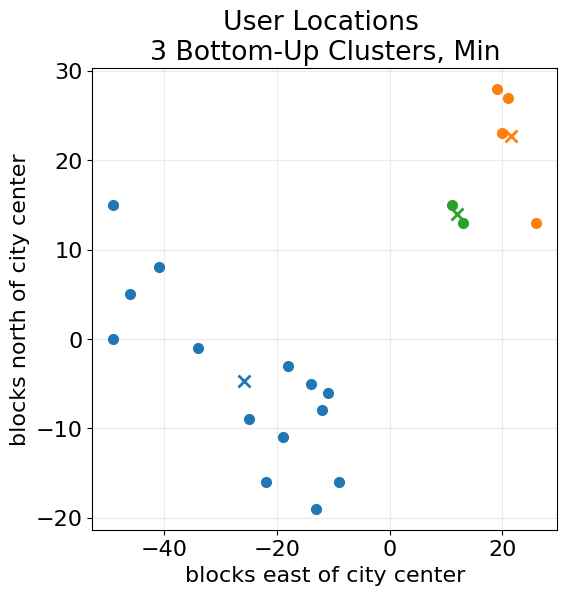

In [119]:
fig, ax = plt.subplots(figsize=(6, 6))

for i, cluster in enumerate(three_clusters):
  x_data = [xi for xi, _ in cluster]
  y_data = [yi for _, yi in cluster]
  plot_handler = ax.plot(x_data, y_data, marker='o', 
    linestyle="None", markersize=7)
  scatter_color = plot_handler[0]._color

  ax.plot(*three_clusters_means[i], marker='x', markeredgewidth=2, 
    markersize=9, color=scatter_color)

ax.set_xlabel("blocks east of city center")
ax.set_ylabel("blocks north of city center")
ax.grid("on")
ax.set_title("User Locations \n3 Bottom-Up Clusters, Min")

plt.show(fig)

### `distance_agg = max`

In [120]:
base_cluster_max = bottom_up_cluster(inputs, max)
base_cluster_max;

In [121]:
three_clusters_max = [get_values(cluster)
                      for cluster in generate_clusters(base_cluster_max, 3)]
three_clusters_max;

In [122]:
three_clusters_max_means = [la.vector_mean(vectors) 
  for vectors in three_clusters_max]
three_clusters_max_means;

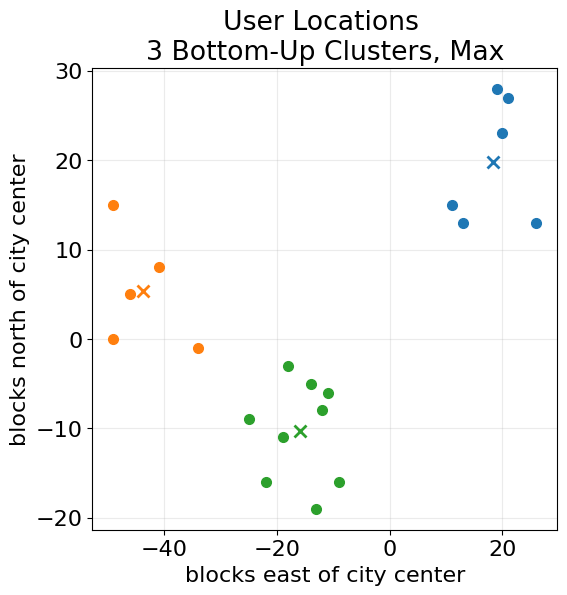

In [123]:
fig, ax = plt.subplots(figsize=(6, 6))

for i, cluster in enumerate(three_clusters_max):
  x_data = [xi for xi, _ in cluster]
  y_data = [yi for _, yi in cluster]
  plot_handler = ax.plot(x_data, y_data, marker='o', 
    linestyle="None", markersize=7)
  scatter_color = plot_handler[0]._color

  ax.plot(*three_clusters_max_means[i], marker='x', markeredgewidth=2, 
    markersize=9, color=scatter_color)

ax.set_xlabel("blocks east of city center")
ax.set_ylabel("blocks north of city center")
ax.grid("on")
ax.set_title("User Locations \n3 Bottom-Up Clusters, Max")

plt.show(fig)